In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Relative abundances

## V1-V2 abundances

### Normalize abundance values

In [2]:
def normalize_abundances(primers, save=False):
    """Generates and saves raw and relative abundance datasets with taxa split into columns.
    
    Input:
    primers: str, should be two digits i,j corresponding the 16S variable regions sequenced.
    
    Output:
    abundance, relative_abundance: raw and relative abundance DataFrames
    
    Saves:
    ../data/splittaxa_{raw, relative}abundances_ViVj.csv
    Removes SRA accessions. 
    """
    
    # read in dataset
    abundance = pd.read_csv(f'../data/taxon_abundance{primers}.tsv', sep='\t')
    abundance = abundance.fillna(0.0)
    abundance.rename(columns={'Unnamed: 0': 'taxon'}, inplace=True)

    # rename samples to just their first number
    sample_name_split = abundance.columns.str.split('.', expand=True)
    sample_ids = sample_name_split.get_level_values(0)
    abundance.columns=sample_ids
    
    # split up taxa and label them
    taxa = abundance['taxon'].str.split(';',expand=True)
    taxa.columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'][:len(taxa.loc[0, :])]
    
    # normalize
    abundance_values = abundance.filter(regex='\d{4}')
    relative_abundance = abundance_values/abundance_values.sum()
    
    # reshape and save
    if save:
        pd.concat([taxa, abundance], axis=1).to_csv(f'../data/splittaxa_rawabundances_V{primers[0]}V{primers[1]}.csv', index=None)
        pd.concat([taxa, relative_abundance], axis=1).to_csv(f'../data/splittaxa_relativeabundances_V{primers[0]}V{primers[1]}.csv', index=None)
    
    return abundance, relative_abundance, taxa

In [3]:
raw12, rel12, taxa12 = normalize_abundances('12')
raw34, rel34, taxa34 = normalize_abundances('34')

## Get de-novo sample ordering

In [4]:
bad_labels = pd.read_csv('../data/denovo_labels.tsv', sep='\n')

In [5]:
with open('../data/denovo_labels.tsv', 'r') as f:
    label_dict = {}
    current_subjects = []
    current_labels = []
    for line in f.readlines():
        linevals = line.split()
        if linevals:
            if 'SRR' in linevals[0]:
                current_subjects = [
                    l.split('.')[0] for l in linevals
                ]
            else:
                current_labels = linevals
                label_dict.update(
                    dict(zip(current_subjects, current_labels))
                )

In [69]:
denovo_clusters = pd.Series(label_dict).astype(int).sort_values()

## Plot relative abundances

### Order dataset for plotting

In [7]:
# sort taxa with most prevalent taxa first
def taxa_by_prevalence(relative_abundance):
    return relative_abundance.sum(axis=1).sort_values(ascending=False).index
    # alternatively may want to combine taxa from both datasets to get a consistent color scheme? 
    # will have to rework my colorations

def gossman_labels(relative_abundance, taxa):
    # sort samples by sums of genera
    sample_sorting_df = pd.concat([
        relative_abundance[taxa['Genus']==genus].sum() for genus in ['Lactobacillus', 'Gardnerella', 'Prevotella']
    ], axis=1).sort_values(by=[0,1,2],ascending=False)
    
    def gossman_label(row):
        if row[0] > 0.5:
            return 0
        elif row[1] > 0.5:
            return 1
        else:
            return 2
    
    return sample_sorting_df.apply(gossman_label, axis=1)

def taxa_to_color(relative_abundance):
    return relative_abundance.ge(0.05).any(axis=1).sum()

### Set up matched coloring for plots

In [53]:
# add a fake spp column for matching
match_taxa12 = taxa12.copy()
match_taxa12['Species'] = None
match_taxa12 = match_taxa12.reset_index().rename(columns={'index':'index_12'})
match_taxa34 = taxa34.reset_index().rename(columns={'index':'index_34'})

# get indices of matching rows
matching_rows = pd.merge(match_taxa12, match_taxa34, how='inner', on=taxa34.columns.to_list())

# generate full df and add colors
all_taxa = pd.concat([
    matching_rows, match_taxa34, match_taxa12
])
all_taxa = all_taxa.drop_duplicates(subset=taxa34.columns)

# add lowest-taxon labels
levels = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
def lowest_taxon(row):
    lowest_taxon = None
    for i, level in enumerate(levels):
        if row[level] is not None:
            lowest_taxon = row[level]
        else:
            return f"{levels[i-1][0]}_{lowest_taxon}"

all_taxa['taxon'] = all_taxa.apply(lowest_taxon, axis=1)

# add in total abundances for each dataset
rel12_label = rel12.ge(0.05).any(axis=1)
rel12_label.name = 'common12'
rel34_label = rel34.ge(0.05).any(axis=1)
rel34_label.name = 'common34'

all_taxa = pd.merge(all_taxa, rel12_label, how='outer', left_on='index_12', right_index=True)\
    .merge(rel34_label, how='outer', left_on='index_34', right_index=True)

# get subset with > 0.5% in either dataset
all_taxa['color_me'] = all_taxa.filter(like='common').any(axis=1)

# now make a random mapping 
rng = np.random.default_rng()

# get length and split the rainbow this way
num_colors = all_taxa['color_me'].sum()
color_nums = np.linspace(0,1,num_colors)
rng.shuffle(color_nums)

# fill empty spots with nan
all_taxa = all_taxa.sort_values('color_me',ascending=False)
all_taxa['color_num'] = np.concatenate([color_nums, [np.nan]*(len(all_taxa) - num_colors)])
all_taxa

,index_12,Domain,Phylum,Class,Order,Family,Genus,Species,index_34,taxon,common12,common34,color_me,color_num
61,295.0,Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Mitochondria,None,None,82.0,F_Mitochondria,False,True,True,0.064516
52,258.0,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Veillonellaceae,Veillonella,None,69.0,G_Veillonella,True,False,True,0.451613
56,264.0,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Sneathia,None,74.0,G_Sneathia,True,True,True,0.903226
55,262.0,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,None,72.0,G_Fusobacterium,True,True,True,0.387097
27,135.0,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,None,38.0,G_Enterococcus,True,False,True,0.806452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59.0,Bacteria,Actinobacteriota,Rubrobacteria,Rubrobacterales,Rubrobacteriaceae,Rubrobacter,None,NaN,G_Rubrobacter,False,NaN,False,NaN
58,58.0,Bacteria,Actinobacteriota,Coriobacteriia,Coriobacteriales,Eggerthellaceae,Enterorhabdus,None,NaN,G_Enterorhabdus,False,NaN,False,NaN
56,56.0,Bacteria,Actinobacteriota,Coriobacteriia,Coriobacteriales,Eggerthellaceae,None,None,NaN,F_Eggerthellaceae,False,NaN,False,NaN
55,55.0,Bacteria,Actinobacteriota,Coriobacteriia,Coriobacteriales,Coriobacteriales Incertae Sedis,None,None,NaN,F_Coriobacteriales Incertae Sedis,False,NaN,False,NaN


In [18]:
# colormaps
tab20 = mpl.cm.get_cmap('tab20')
tab20b = mpl.cm.get_cmap('tab20b')
tab20c = mpl.cm.get_cmap('tab20c')
rainbow = mpl.cm.get_cmap('rainbow')

### Plot

In [54]:
def plot_abundances(data, cluster_labels, taxa_order, taxa_colors, colormap, ax):
    """Plots relative abundances.
    
    data: relative abundance DataFrame with taxa = rows and samples = columns
    cluster_labels: gives order of samples by its index, and labels clusters by integers (starting at 0)
    taxa_order: index showing order of taxa (rows)
    taxa_colors: df indexed by taxa nums, has respective colornums and taxon labels
    ax: Axes object to plot to
    """
    # get number of samples
    n_cols = len(data.iloc[0])
    
    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(n_cols)
    
    # Generate the cluster-separated horizontal offset
    x = np.arange(n_cols) + (cluster_labels*0.3)
    
    # Determine how many taxa to color
    num_important_taxa = taxa_to_color(data)

    # Plot bars and create text labels for the table
    for i, index in enumerate(taxa_order):
        if i < num_important_taxa:
            color = colormap(taxa_colors.loc[index, 'color_num'])
            label = taxa_colors.loc[index, 'taxon']
        else:
            color = 'grey'
            label = None
        y = data.loc[index, cluster_labels.index]
        ax.bar(x, y, bottom=y_offset, color=color, edgecolor='black', label=label)
        y_offset = y_offset + y
    
    # do x labels
    ax.set_xticks(ticks=x)
    ax.set_xticklabels(labels=cluster_labels.index, fontdict={'fontsize':'x-small'}, rotation=90)
    # change y labels to percents
    ax.set_ylabel('Relative abundance')
    # add legend
    ax.legend(loc='upper left', bbox_to_anchor=(0., -0.2), ncol=4)

### V1V2 relative abundances

In [55]:
gossman12 = gossman_labels(rel12, taxa12)
taxa_order12 = taxa_by_prevalence(rel12)
colors12 = all_taxa.set_index('index_12')[['color_num', 'taxon']]

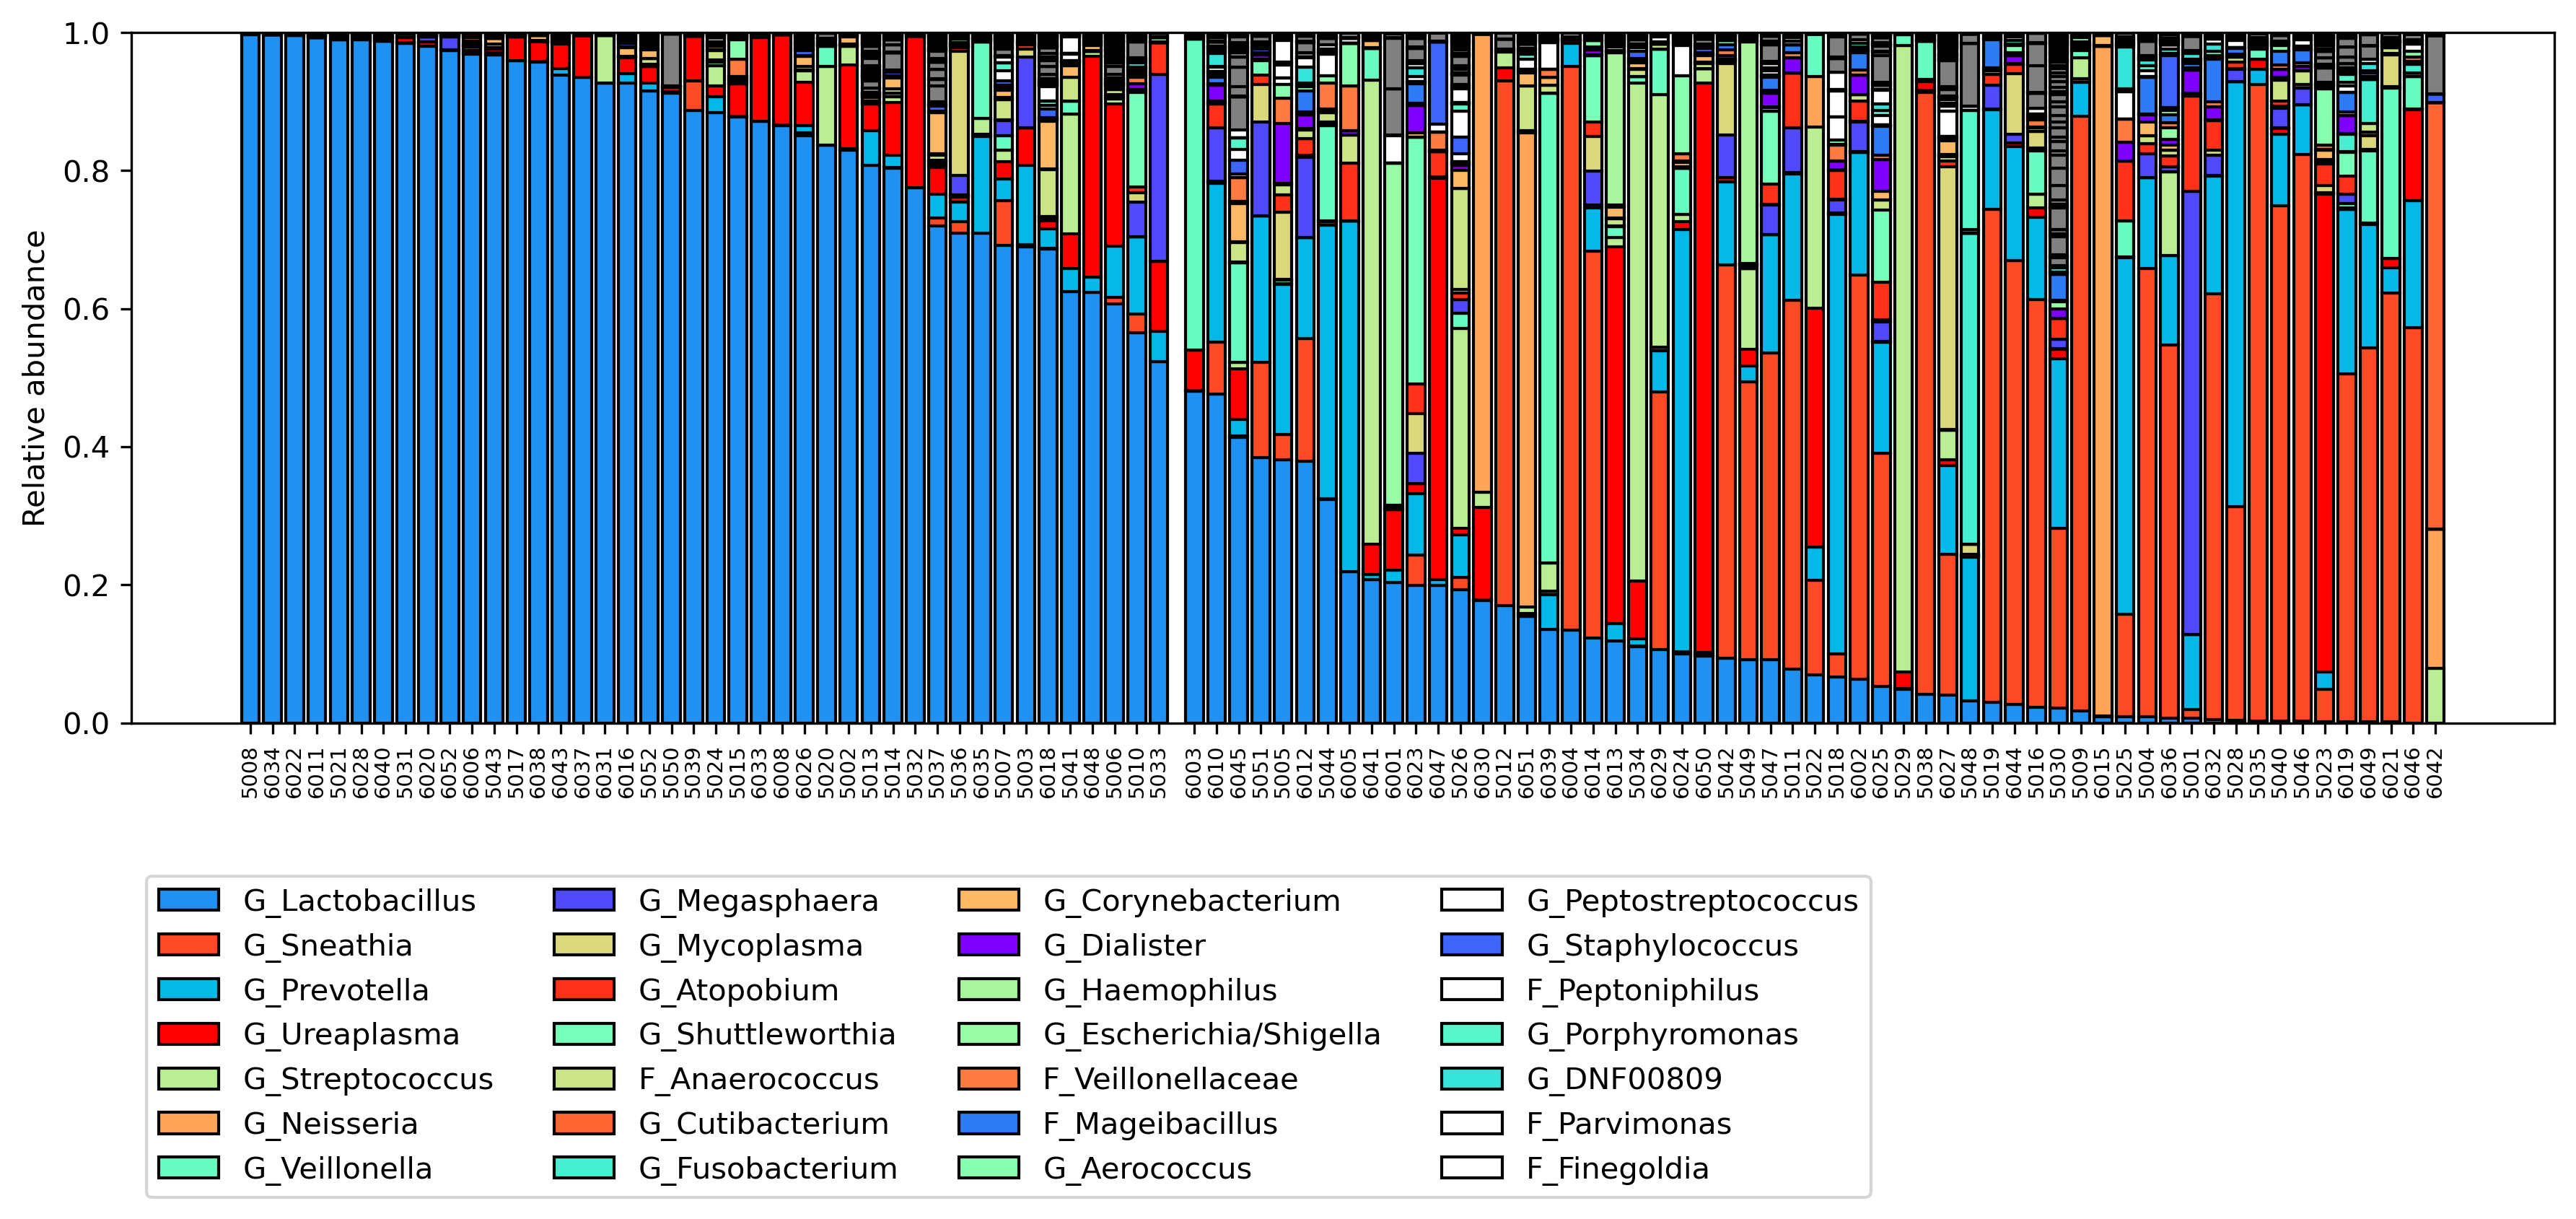

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)
plot_abundances(rel12, gossman12, taxa_order12, colors12, rainbow, ax)
plt.tight_layout()
plt.savefig('../figs/relative_abundance_v1v2.jpg')
plt.show()

### V3V4 relative abundances

In [58]:
gossman34 = gossman_labels(rel34, taxa34)
taxa_order34 = taxa_by_prevalence(rel34)
colors34 = all_taxa.set_index('index_34')[['color_num', 'taxon']]

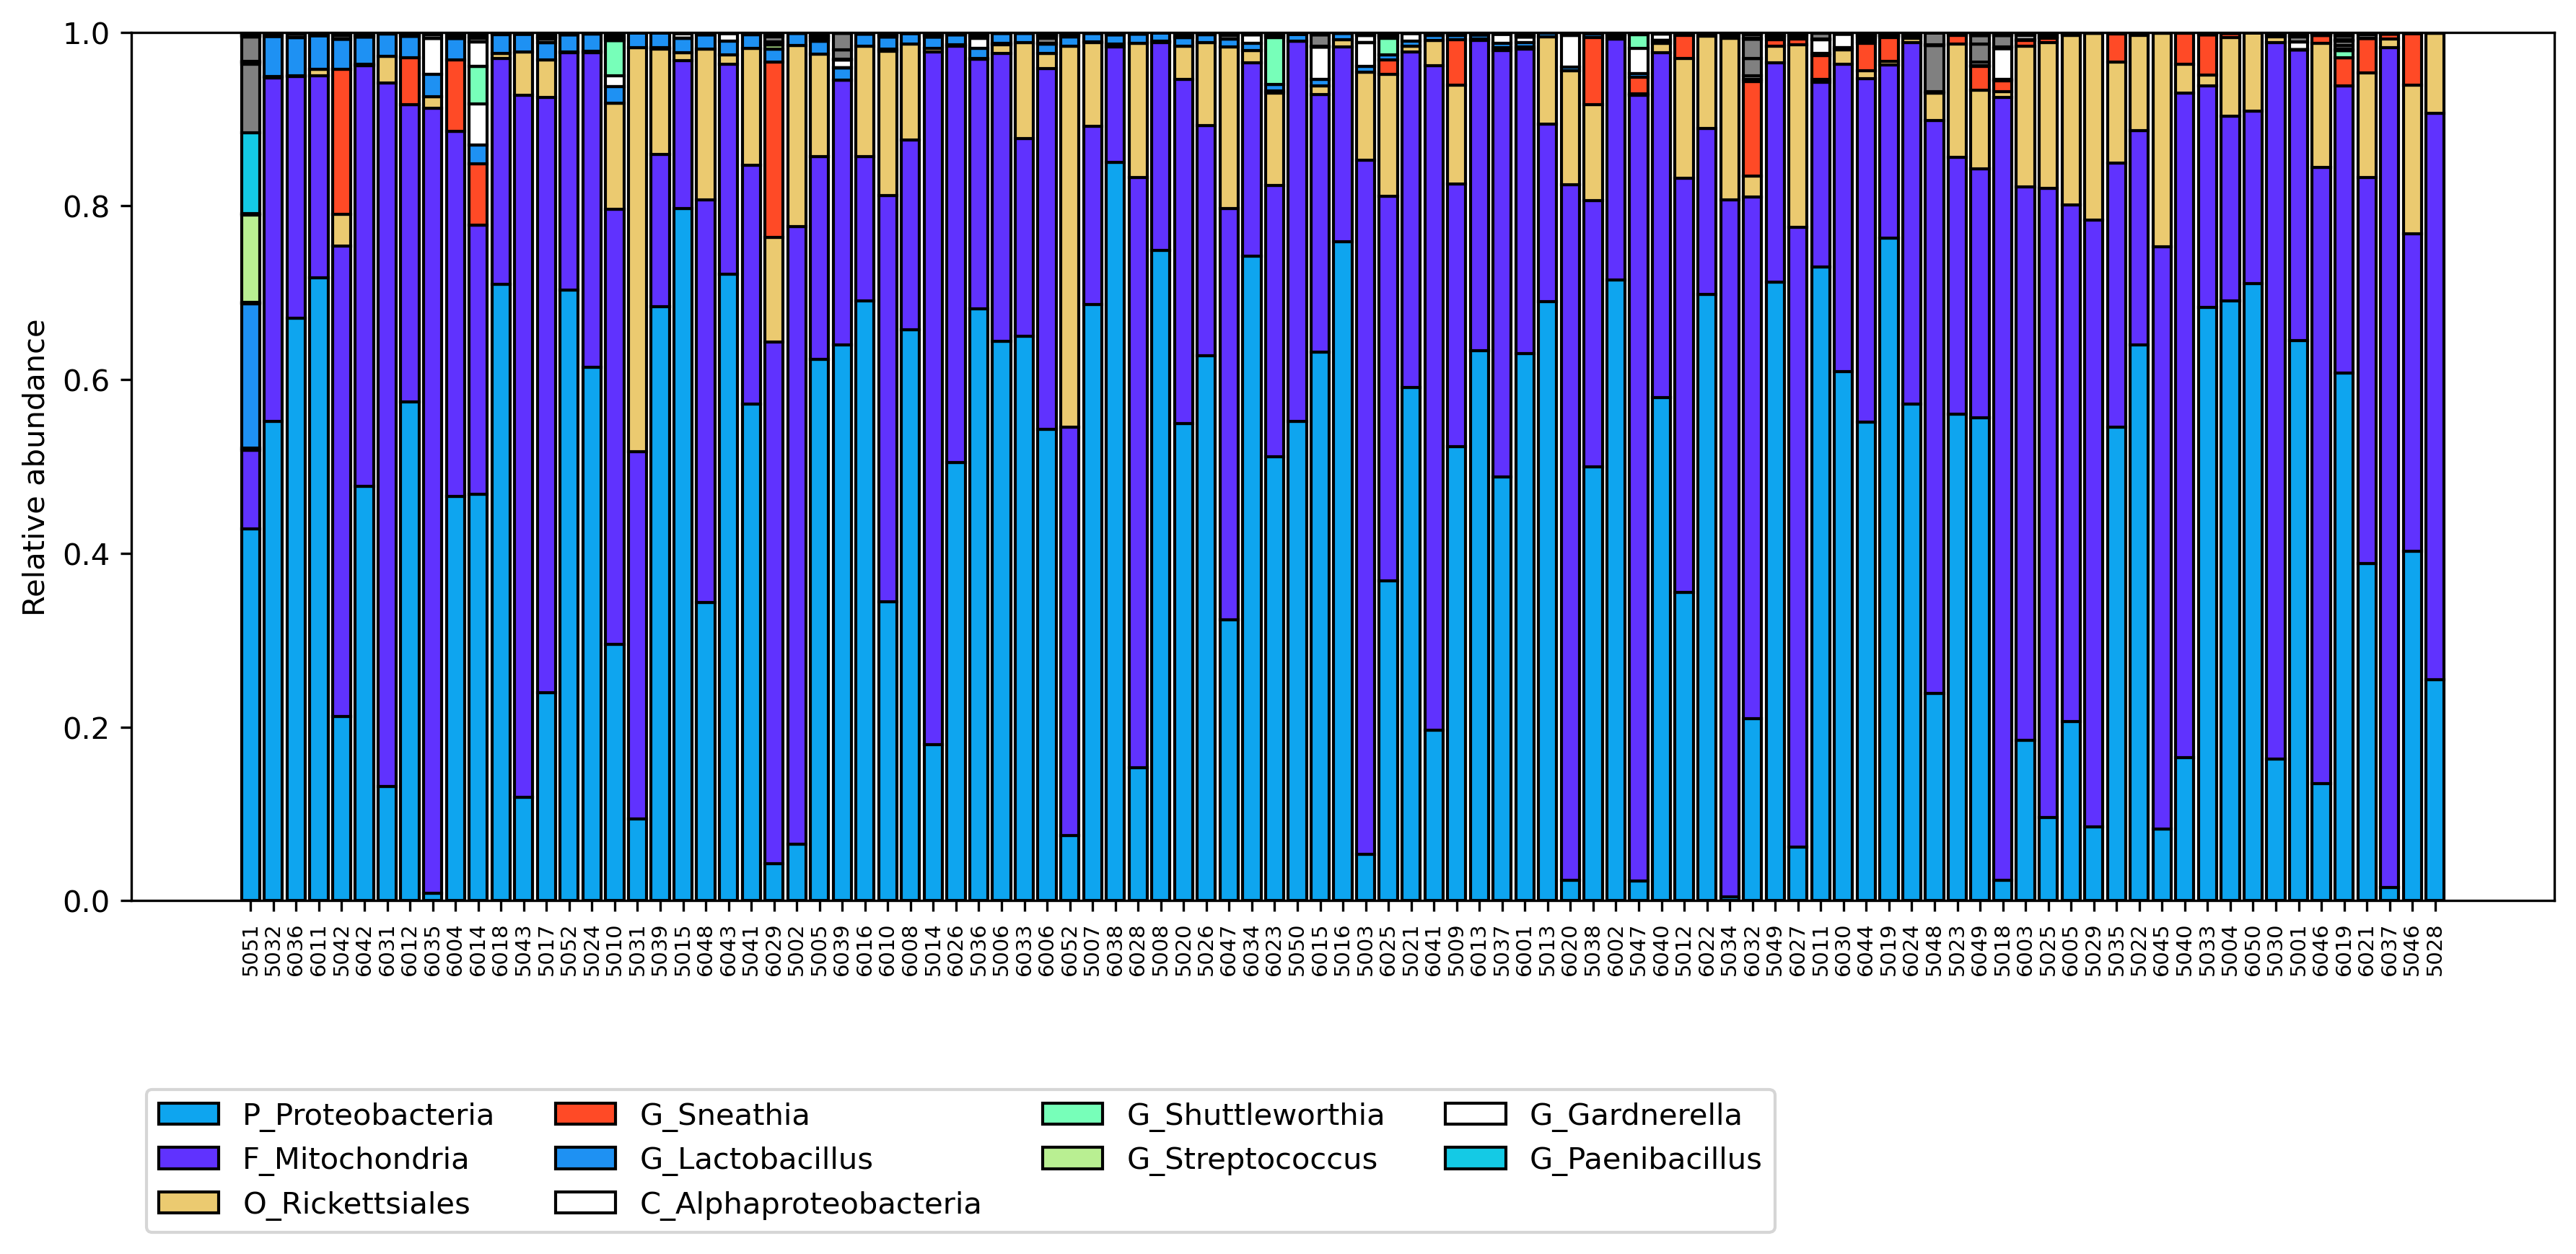

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)
plot_abundances(rel34, gossman34, taxa_order34, colors34, rainbow, ax)
plt.tight_layout()
plt.savefig('../figs/relative_abundance_v3v4.jpg')
plt.show()

### De novo clusters

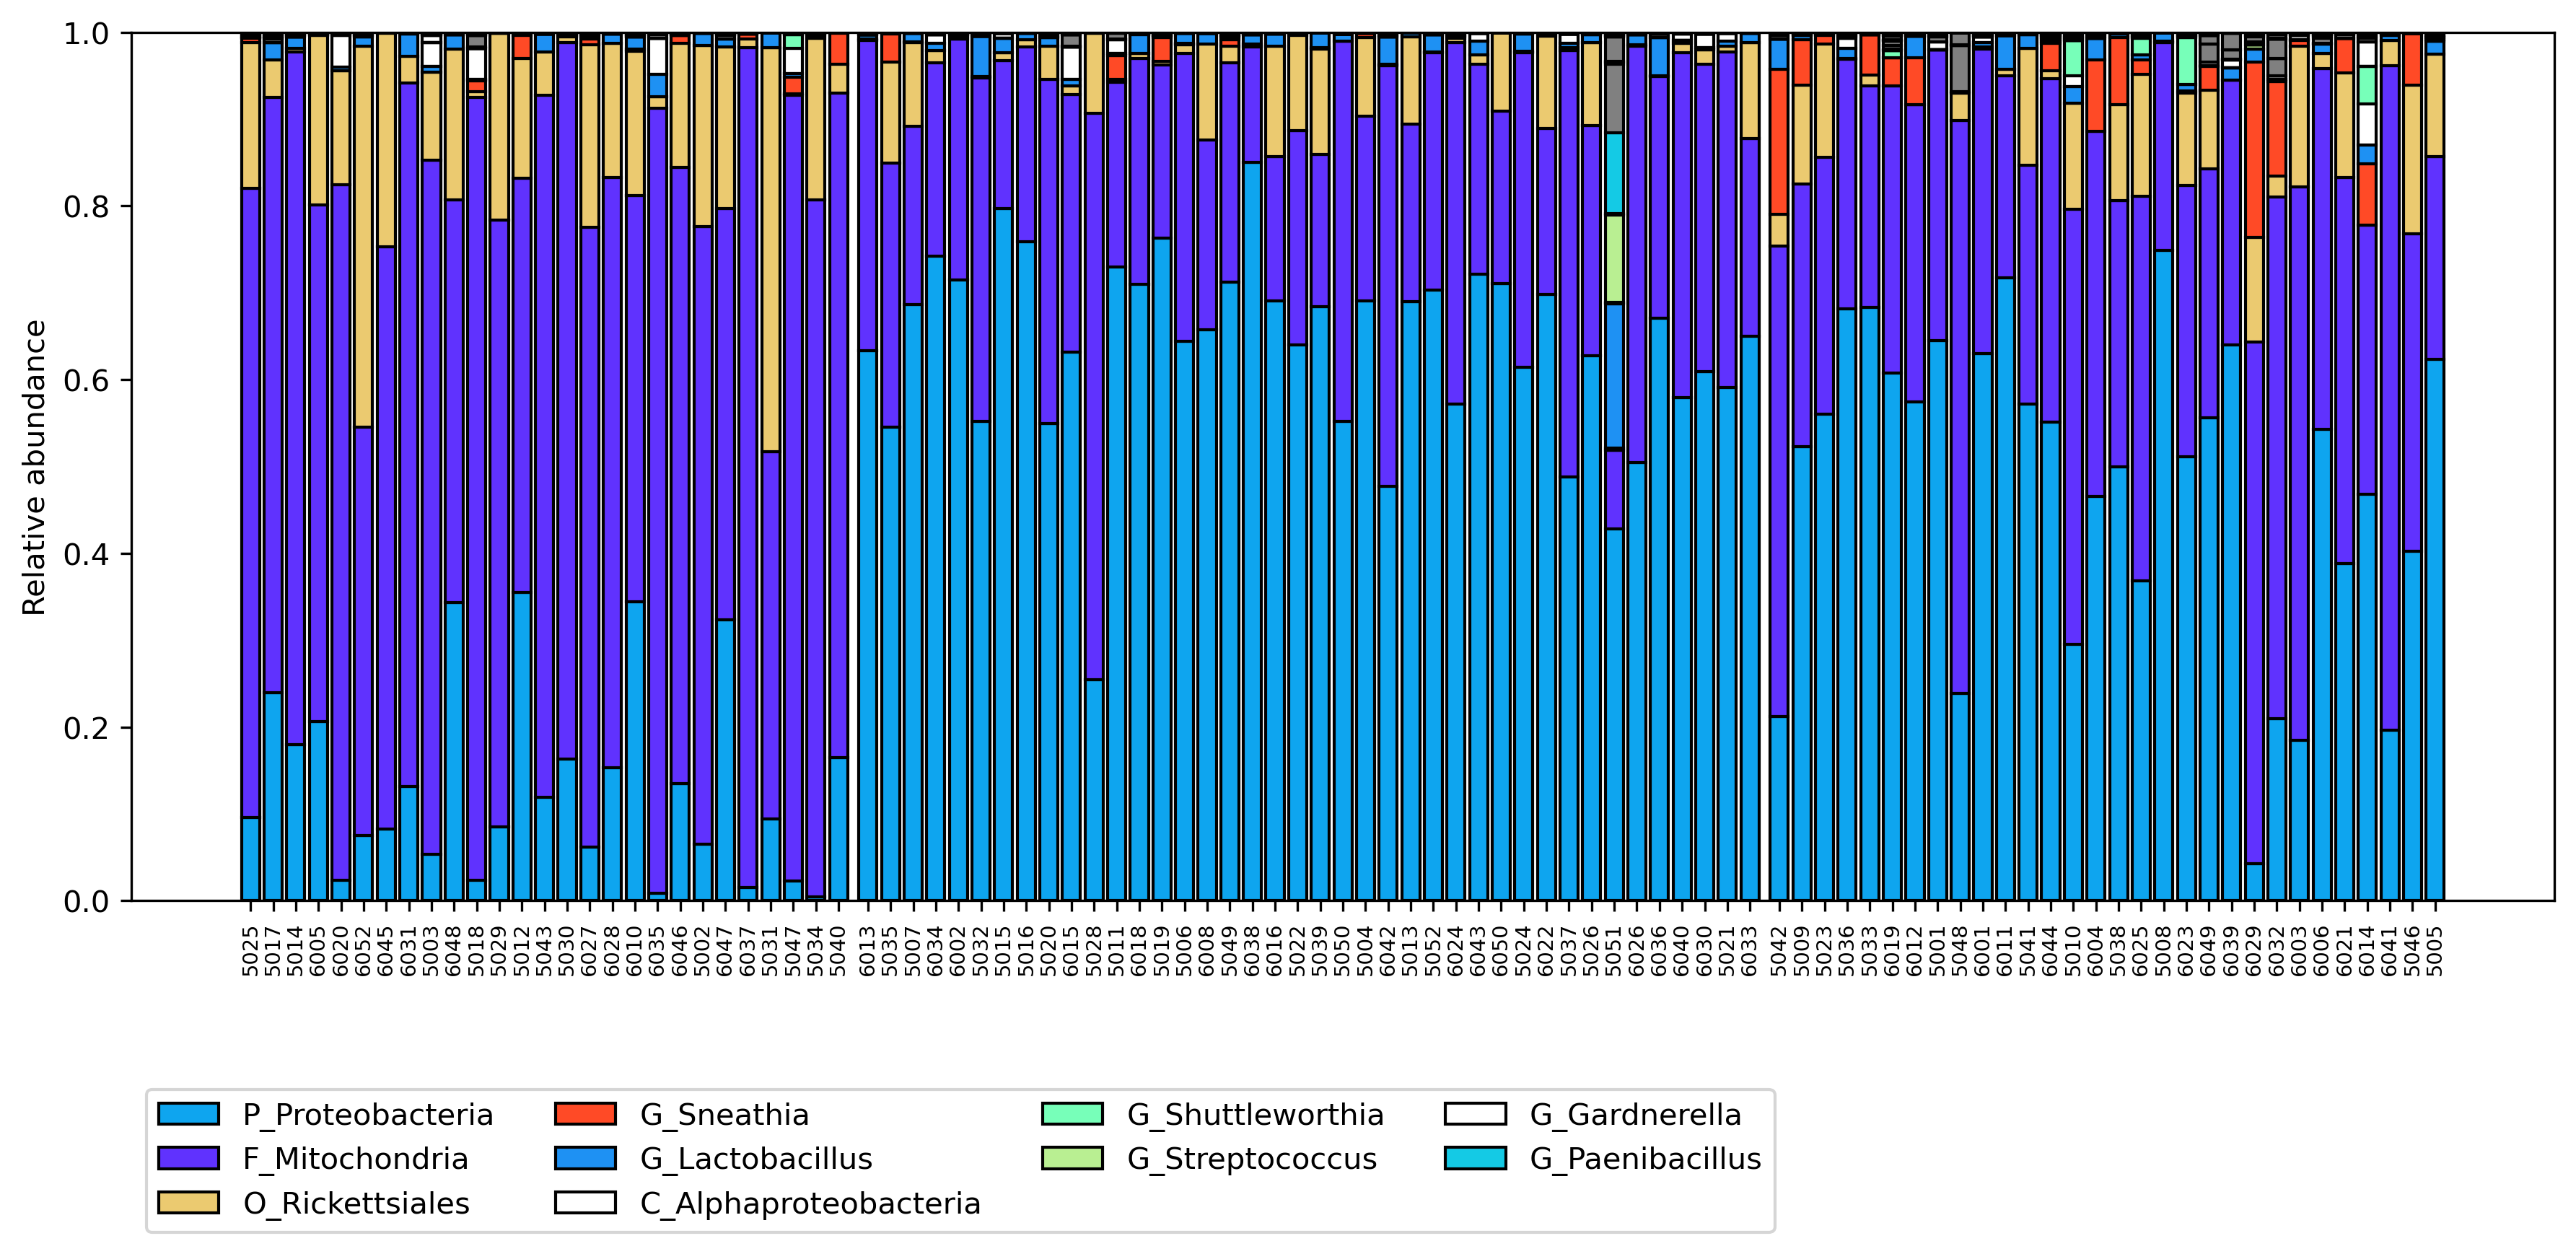

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)
plot_abundances(rel34, denovo_clusters, taxa_order34, colors34, rainbow, ax)
plt.tight_layout()
plt.savefig('../figs/relative_abundance_denovo_v3v4.jpg')
plt.show()

In [73]:
set(rel12.columns) - set(denovo_clusters.index)

{'5044', '6051'}

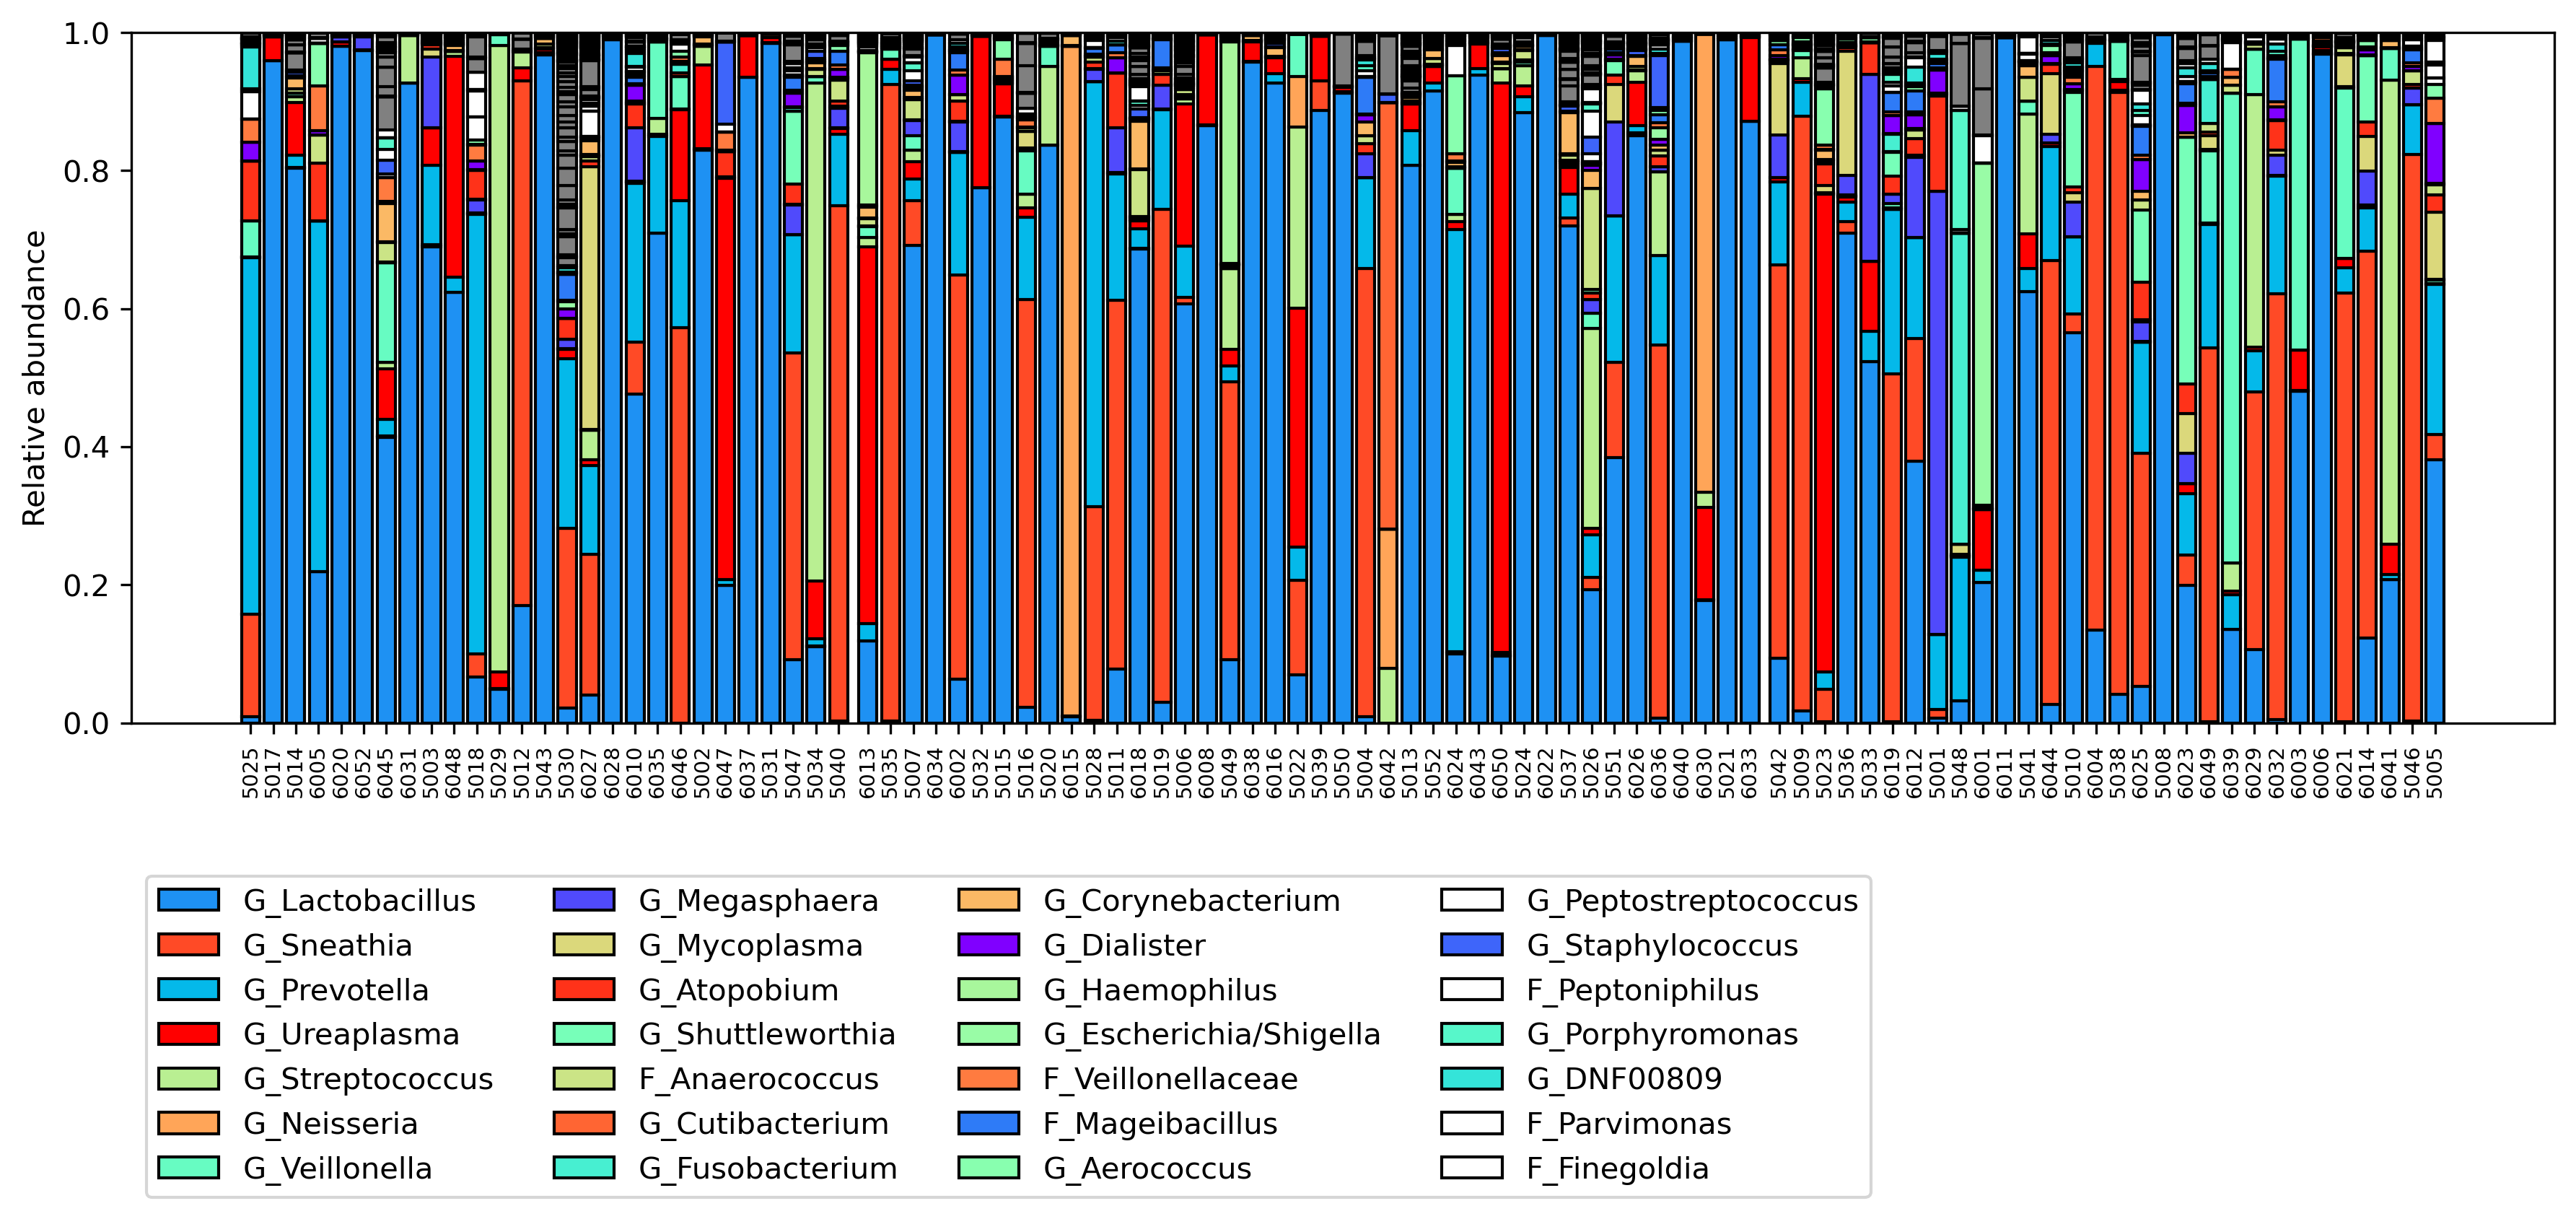

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)
plot_abundances(rel12[rel12.columns.difference(['5044', '6051'], sort=False)], 
                denovo_clusters, taxa_order12, colors12, rainbow, ax)
plt.tight_layout()
plt.savefig('../figs/relative_abundance_denovo_v1v2.jpg')
plt.show()